In [1]:
import numpy as np
import pandas as pd
from collections import Counter
import unicodedata
import re
from typing import Set
from sklearn.cluster import KMeans
import community
import networkx as nx
import matplotlib.pyplot as plt
import seaborn as sns
import ast

pd.set_option('display.max_columns', None)

df_raw = pd.read_csv('data/x-raw.csv')
df_toxic = pd.read_csv('data/x-toxicity_attacks.csv')
df_related = pd.read_csv('data/x-related-factchecks.csv')
df_cluster = pd.read_csv('data/x-clustering.csv')
df_metadata = pd.read_csv('data/x-clustering-cluster_metadata.csv')

df_toxic['date'] = pd.to_datetime(df_toxic['g-x-last_month - content_id → date'])
df_toxic.drop('g-x-last_month - content_id → date', axis = 1, inplace = True)
df_toxic['insertion_date'] = pd.to_datetime(df_toxic['ìnsertion_date']) 
df_toxic.drop('ìnsertion_date', axis = 1, inplace = True) # hay un misspelling
df_toxic.drop('insertion_date', axis = 1, inplace = True) # hemos chequeado que es constante, parece la fecha de inserción del ejercicio
df_raw['date'] = pd.to_datetime(df_raw['date'])

df_raw_toxic = df_raw.merge(
   df_toxic,
   left_on=['link', 'date','type'],
   right_on=['content_id', 'date','type'],
   how='inner'
).drop('link', axis=1)

df_raw_toxic_related = df_raw_toxic.merge(
   df_related,
   left_on=['content_id'],
   right_on=['content_id'],
   how='left'
)

df_raw_toxic_related_cluster = df_raw_toxic_related.merge(
   df_cluster,
   left_on=['content_id'],
   right_on=['content_id'],
   how='left'
)

df_main = df_raw_toxic_related_cluster.copy()

df_main.drop(columns = ['msgId','parentId','user.username','user.name','user.gender'], inplace = True)
df_main['sentiment'] = df_main['sentiment'].apply(lambda x: 1 if x == 'POSITIVE' else (0 if x == 'OBJETIVE' else -1))
df_main['toxic'] = df_main['toxicity_condition'].apply(lambda x: 1 if x == 'toxic' else 0)
df_main.drop('toxicity_condition', axis = 1, inplace = True)

# Eliminar puntos y convertir a números
df_main['user.followers'] = pd.to_numeric(
    df_main['user.followers'].str.replace('.', '', regex=False),
    errors='coerce'  # Convierte valores problemáticos a NaN
).astype('Int64')  # Usa Int64 para permitir NaN en columnas de enteros

df_main['user.friends'] = df_main['user.friends'].astype(int)

df_main.drop('categories', axis = 1, inplace = True)


def normalize_text(text: str) -> str:
    text = unicodedata.normalize('NFKD', text)
    text = ''.join(c for c in text if not unicodedata.combining(c))
    text = re.sub(r'[^a-zA-Z0-9\s]', '', text)
    return text.lower()

def extract_keywords(df_metadata: pd.DataFrame) -> set:
    keywords_set = set()
    for keywords in df_metadata['keywords'].dropna():
        palabras = [normalize_text(palabra.strip()) for palabra in keywords.split(',')]
        keywords_set.update(palabras)
    return keywords_set

keywords_set = extract_keywords(df_metadata)
print(f"Keywords normalizadas: {len(keywords_set)}")

keywords_bancarias = {
   'Entidades Bancarias y Financieras': [
       'bbva', 'banco santander', 'bankia', 'banco de espana', 
       'banco central europeo', 'banc sabadell', 'bankinter', 
       'unicaja', 'caixabank', 'ibercaja', 'openbank', 
       'kutxabank', 'evo banco', 'banamex', 'banca espanola',
       'bancos privados', 'bancos digitales', 'bancos eticos'
   ],
   
   'Productos y Servicios Financieros': [
       'hipotecas', 'creditos', 'prestamo', 'tarjetas de credito',
       'cuentas digitales', 'planes de pensiones', 'fondos de inversion',
       'cuentas remuneradas', 'servicios financieros', 'banca digital',
       'banca movil'
   ],
   
   'Términos Financieros y Económicos': [
       'euribor', 'tipos de interes', 'margen de intereses', 
       'dividendo', 'activos financieros', 'mercados financieros',
       'finanzas digitales', 'fintech', 'rentabilidad',
       'irph', 'clausulas suelo', 'clausulas abusivas'
   ],
   
   'Personal y Gestión Bancaria': [
       'ana botin', 'goirigolzarri', 'banqueros centrales',
       'carlos torres', 'ejecutivos', 'gestion financiera'
   ],
   
   'Regulación y Supervisión': [
       'regulacion', 'comision europea',
       'cnmc', 'politica monetaria', 'bce', 'ecb'
   ],
   
   'Operaciones y Servicios': [
       'transferencias bancarias', 'metodos de pago', 'atencion al cliente',
       'digitalizacion', 'interoperabilidad', 'cambio de banco',
       'visa', 'apple pay'
   ],
   
   'Problemas y Controversias': [
       'abusos bancarios', 'rescates bancarios', 'puertas giratorias',
       'estafas financieras', 'fraude', 'phishing', 'ciberataque',
       'bloqueo de cuentas', 'fallos de seguridad', 'reclamaciones'
   ]
}

# Para obtener todas las keywords en una lista plana
todas_keywords_bancarias = [keyword for categoria in keywords_bancarias.values() for keyword in categoria]

# Para obtener el número total de keywords
total_keywords = len(todas_keywords_bancarias)
print()
print(f"Total de keywords bancarias identificadas: {total_keywords}")

Keywords normalizadas: 1303

Total de keywords bancarias identificadas: 71


In [2]:
df_metadata['keywords_tratadas'] = df_metadata['keywords'].fillna('').apply(lambda x: [normalize_text(k.strip()) for k in x.split(',')] if x else [])

df_metadata['es_bancario'] = df_metadata['keywords_tratadas'].apply(lambda x: bool(set(x) & set(todas_keywords_bancarias))).astype(int)

df_metadata.drop('keywords', axis = 1, inplace = True)

In [3]:
df_main_clusters = df_main.merge(df_metadata[['cluster_id', 'es_bancario','narrative']], 
                                 on = 'cluster_id', 
                                 how = 'left')

df_main_clusters['RT'] = df_main_clusters['type'].apply(lambda x: 1 if x == 'Retweet' else 0)
df_main_clusters.drop('type', axis = 1, inplace = True)

df_main_clusters['type_attack'] = df_main_clusters['type_attack'].fillna('no_attack')

df_main_clusters['object_attack'] = df_main_clusters['object_attack'].apply(
    lambda x: ast.literal_eval(x) if pd.notna(x) else []
)

object_attack_set = set(
    element
    for row in df_main_clusters['object_attack']
    for element in row
)

object_attack_set = set({normalize_text(x) for x in object_attack_set})

df_main_clusters['claim_url_bool'] = df_main_clusters['claim_url'].notna().astype(int)

In [4]:
df_metadata.head(1).keywords_tratadas.values

array([list(['crisis economica', 'oro', 'instituciones financieras', 'gestion etica'])],
      dtype=object)

In [5]:
# Crear columnas para día, hora y minuto
df_main_clusters = df_main_clusters.sort_values(by = 'date')
df_main_clusters['dia'] = df_main_clusters['date'].dt.day
df_main_clusters['hora'] = df_main_clusters['date'].dt.hour
df_main_clusters['minuto'] = df_main_clusters['date'].dt.minute

# Características estáticas de los clústers


**Características Estáticas Constantes**: La **narrativa** es un ejemplo de característica estática constante, ya que no varía con el tiempo.

**Características Estáticas Variables**: Existen características que varían día a día o mes a mes, como el volumen de los tuits o la toxicidad

In [8]:
# Crear DataFrame base
df_cluster_estatico = df_metadata.copy()

# Función para calcular conteos por cluster con condición específica
def obtener_conteos_cluster(df, condicion=None, columna_conteo='cluster_id'):
    datos = df if condicion is None else df[condicion]
    conteos = datos[columna_conteo].value_counts().reset_index(drop=False)
    return conteos

# Definir todos los tipos de métricas a calcular
metricas = {
    'total': (None, 'tamaño'),
    'toxico': (df_main_clusters['toxic'] > 0, 'conteo_toxicos'),
    'bulo': (df_main_clusters['es_bancario'] > 0, 'conteo_bulos'),
    'negativo': (df_main_clusters['sentiment'] == -1, 'conteo_sentimiento_neg'),
    'sarcasmo': (df_main_clusters['type_attack'] == 'sarcasm', 'conteo_sarcasmo'),
    'insulto': (df_main_clusters['type_attack'] == 'insult', 'conteo_insultos'),
    'discriminatorio': (df_main_clusters['type_attack'] == 'discriminatory', 'conteo_discriminacion'),
    'amenaza': (df_main_clusters['type_attack'] == 'threat', 'conteo_amenazas'),
    'profanidad': (df_main_clusters['type_attack'] == 'profanity', 'conteo_profanidad'),
    'retweet': (df_main_clusters['RT'] == 1, 'conteo_retweets')  # Añadido conteo de retweets
}

# Calcular conteos para cada métrica
conteos = {
    key: obtener_conteos_cluster(df_main_clusters, condicion) 
    for key, (condicion, _) in metricas.items()
}

# Renombrar columnas para cada DataFrame de conteos
for key, (_, nombre_columna) in metricas.items():
    conteos[key].columns = ['cluster_id', nombre_columna]

# Combinar todos los conteos en un solo DataFrame
resultado = conteos['total']
for key in metricas.keys():
    if key != 'total':
        resultado = resultado.merge(conteos[key], on='cluster_id', how='left')

# Calcular ratios para todas las métricas excepto el total
ratios = {
    f'ratio_{nombre_columna[7:]}': nombre_columna 
    for _, nombre_columna in metricas.values()
    if nombre_columna != 'tamaño'
}

for nombre_ratio, columna_conteo in ratios.items():
    resultado[nombre_ratio] = resultado[columna_conteo] / resultado['tamaño']

# Limpiar valores NaN y hacer merge con el DataFrame original
resultado.fillna(0, inplace=True)
columnas_a_mantener = ['cluster_id', 'tamaño'] + list(ratios.keys())
df_cluster_estatico = df_cluster_estatico.merge(
    resultado[columnas_a_mantener], 
    on='cluster_id', 
    how='left'
)

# Calcular tamaño relativo
df_cluster_estatico['tamaño_rel'] = df_cluster_estatico['tamaño'] / df_cluster_estatico['tamaño'].sum()

# Calcular estadísticas de seguidores por cluster
estadisticas_followers = df_main_clusters.groupby('cluster_id')['user.followers'].agg([
    ('followers_total', 'sum')
]).reset_index()

# Hacer merge con el DataFrame existente
df_cluster_estatico = df_cluster_estatico.merge(
    estadisticas_followers,
    on='cluster_id',
    how='left'
)

# Calcular el alcance relativo (proporción del alcance total que representa cada cluster)
df_cluster_estatico['alcance_relativo'] = df_cluster_estatico['followers_total'] / df_cluster_estatico['followers_total'].sum()

# Calcular alcance promedio por tweet en el cluster
df_cluster_estatico['alcance_promedio_tweet'] = df_cluster_estatico['followers_total'] / df_cluster_estatico['tamaño']

In [9]:
df_cluster_estatico.head()

,cluster_id,narrative,keywords_tratadas,es_bancario,tamaño,ratio_toxicos,ratio_bulos,ratio_sentimiento_neg,ratio_sarcasmo,ratio_insultos,ratio_discriminacion,ratio_amenazas,ratio_profanidad,ratio_retweets,tamaño_rel,followers_total,alcance_relativo,alcance_promedio_tweet
0,-1,En un contexto de crisis económica y desiguald...,"[crisis economica, oro, instituciones financie...",0,41585,0.290682,0.0,0.923434,0.243477,0.064543,0.025754,0.004858,0.002501,0.404136,0.206421,891027225,0.280159,21426.649633
1,0,La comunidad se une para apoyar a Seunghan de ...,"[seunghan, bullying, apoyo, justicia]",0,177,0.016949,0.0,0.977401,0.039548,0.000000,0.000000,0.000000,0.000000,0.175141,0.000879,22394,0.000007,126.519774
2,1,El intenso debate en torno al cricket afgano r...,"[cricket, afganistan, talibanes, derechos huma...",0,233,0.682403,0.0,0.939914,0.283262,0.291845,0.042918,0.012876,0.060086,0.111588,0.001157,274187,0.000086,1176.76824
3,2,Un conflicto global se intensifica con la reci...,"[conflicto, israel, iran, balonmano]",0,41,0.487805,0.0,1.000000,0.000000,0.000000,0.000000,0.487805,0.000000,0.000000,0.000204,18061,0.000006,440.512195
4,3,"El presidente de Quantum Minería, Javier Merin...","[javier merino, quantum mineria, banco santand...",1,80,0.187500,1.0,1.000000,0.187500,0.000000,0.000000,0.000000,0.000000,0.362500,0.000397,128396,0.00004,1604.95


# Análisis temporales

In [11]:
df_main_clusters_ampliado = df_main_clusters.merge(
   df_cluster_estatico,
   on=['cluster_id', 'narrative', 'es_bancario'],
   how='left',
   suffixes=('', '_cluster')
)

toxicidad_diaria = df_main_clusters_ampliado.groupby('dia')['toxic'].agg([
    ('toxicidad_media', 'mean'),
    ('num_tweets', 'count')
]).reset_index().sort_values('dia')

bulos_diario = df_main_clusters_ampliado.groupby('dia')['claim_url_bool'].agg([
    ('ratio_bulos_diarios', 'mean'),
    ('bulos_totales_diario', 'count')
]).reset_index().sort_values('dia')

usuarios_diaria = df_main_clusters_ampliado.groupby('dia')['user.id'].agg([
    ('num_usuarios_distintos', 'nunique')
]).reset_index().sort_values('dia')

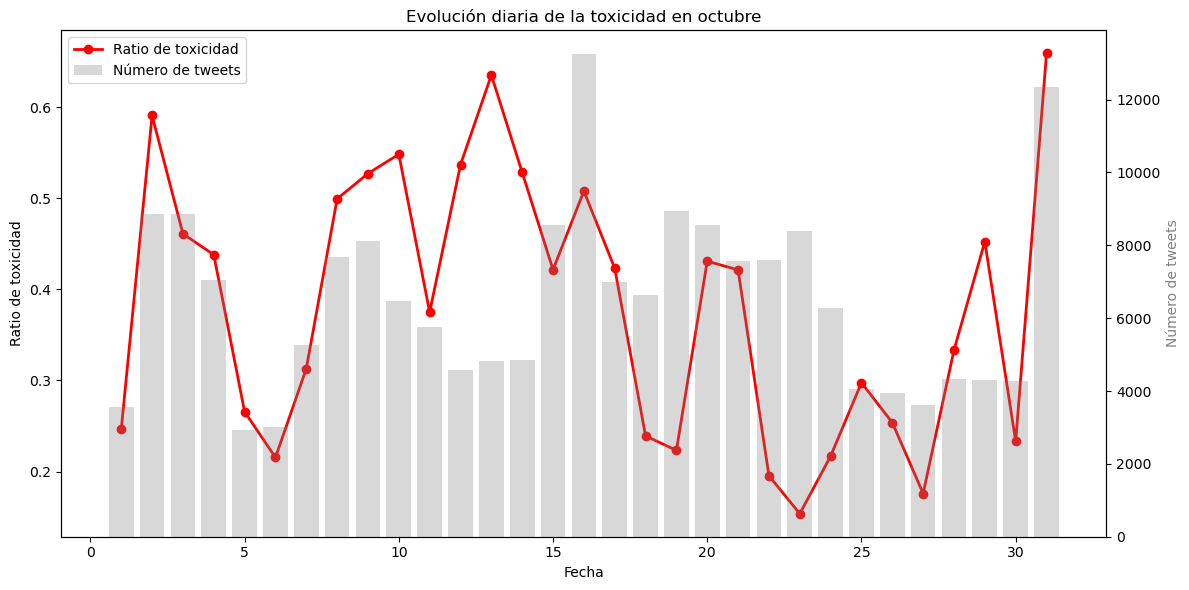

In [12]:
plt.figure(figsize=(12, 6))
ax1 = plt.gca()
ax2 = ax1.twinx() 

# Línea de toxicidad media
line1 = ax1.plot(toxicidad_diaria['dia'], 
                 toxicidad_diaria['toxicidad_media'], 
                 color='red', 
                 marker= 'o',
                 linewidth=2,
                 label='Ratio de toxicidad')


# Barras de volumen de tweets
bars = ax2.bar(toxicidad_diaria['dia'], 
               toxicidad_diaria['num_tweets'], 
               alpha=0.3, 
               color='gray',
               label='Número de tweets')

# Configuración de ejes y etiquetas
ax1.set_xlabel('Fecha')
ax1.set_ylabel('Ratio de toxicidad', color='black')
ax2.set_ylabel('Número de tweets', color='gray')

# Rotar fechas para mejor visualización
plt.xticks(rotation=45)


lines1, labels1 = ax1.get_legend_handles_labels()
lines2, labels2 = ax2.get_legend_handles_labels()
ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')

plt.title('Evolución diaria de la toxicidad en octubre')
plt.tight_layout()
plt.show()

In [13]:
# Cálculo de todas las métricas por tipo
df_metricas = df_main_clusters_ampliado.groupby(['dia', 'es_bancario']).agg(
    ratio_toxicidad=('toxic', 'mean'),
    total_tweets=('toxic', 'count'),
    ratio_bulos=('claim_url_bool', 'mean'),
    ratio_usuarios=('user.id', lambda x: x.nunique()/len(x)),
    total_usuarios=('user.id', 'nunique')
).reset_index()

# Cálculo del ratio bancario/no bancario por día
total_por_dia = df_metricas.groupby('dia')['total_tweets'].sum().reset_index()
df_metricas = df_metricas.merge(total_por_dia, on='dia', suffixes=('', '_dia'))
df_metricas['ratio_tipo'] = df_metricas['total_tweets'] / df_metricas['total_tweets_dia']

df_metricas['ratio_toxicidad_ponderada'] = df_metricas['ratio_toxicidad'] * df_metricas['ratio_tipo'] * df_metricas['ratio_usuarios']

In [14]:
df_metricas.head()

,dia,es_bancario,ratio_toxicidad,total_tweets,ratio_bulos,ratio_usuarios,total_usuarios,total_tweets_dia,ratio_tipo,ratio_toxicidad_ponderada
0,1,0,0.257490,2470,0.002024,0.768016,1897,3561,0.693625,0.137169
1,1,1,0.220898,1091,0.000917,0.826764,902,3561,0.306375,0.055953
2,2,0,0.565530,6127,0.000000,0.742941,4552,8849,0.692395,0.290913
3,2,1,0.648053,2722,0.001102,0.818883,2229,8849,0.307605,0.163240
4,3,0,0.543521,5549,0.001261,0.815282,4524,8874,0.625310,0.277089


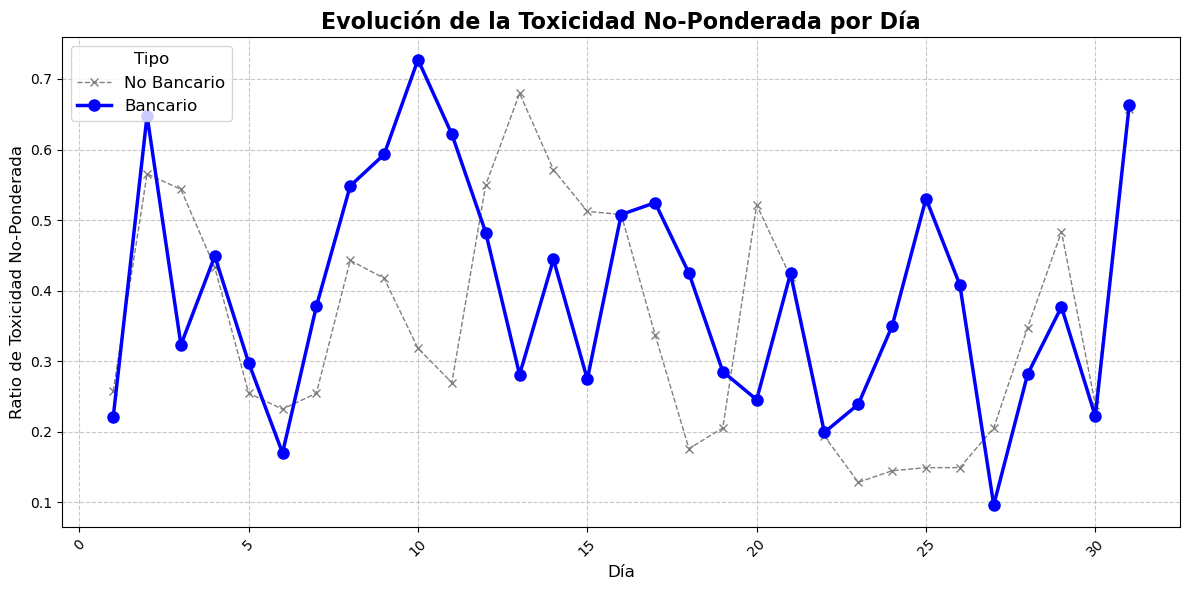

In [15]:
plt.figure(figsize=(12, 6))

# Colores y estilos para cada grupo
colores = {0: 'gray', 1: 'blue'}
estilos = {0: '--', 1: '-'}
ancho_linea = {0: 1, 1: 2.5}
marcadores = {0: 'x', 1: 'o'}

# Graficar por separado para bancario y no bancario
for es_bancario in [0, 1]:
    data_tipo = df_metricas[df_metricas['es_bancario'] == es_bancario]
    plt.plot(data_tipo['dia'], data_tipo['ratio_toxicidad'], 
             label='Bancario' if es_bancario else 'No Bancario',
             color=colores[es_bancario],
             linestyle=estilos[es_bancario],
             linewidth=ancho_linea[es_bancario],
             marker=marcadores[es_bancario],
             markersize=8 if es_bancario else 6)

# Mejorar los ejes y el diseño del gráfico
plt.title('Evolución de la Toxicidad No-Ponderada por Día', fontsize=16, fontweight='bold')
plt.xlabel('Día', fontsize=12)
plt.ylabel('Ratio de Toxicidad No-Ponderada', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='upper left', title='Tipo', title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


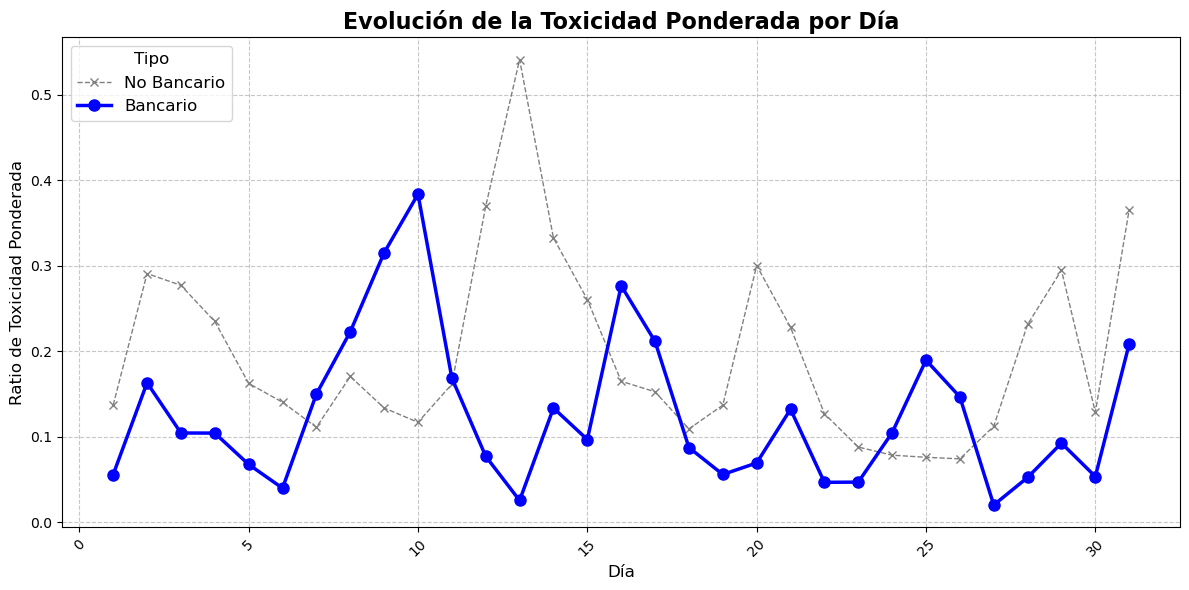

In [16]:
plt.figure(figsize=(12, 6))

# Colores y estilos para cada grupo
colores = {0: 'gray', 1: 'blue'}
estilos = {0: '--', 1: '-'}
ancho_linea = {0: 1, 1: 2.5}
marcadores = {0: 'x', 1: 'o'}

# Graficar por separado para bancario y no bancario
for es_bancario in [0, 1]:
    data_tipo = df_metricas[df_metricas['es_bancario'] == es_bancario]
    plt.plot(data_tipo['dia'], data_tipo['ratio_toxicidad_ponderada'], 
             label='Bancario' if es_bancario else 'No Bancario',
             color=colores[es_bancario],
             linestyle=estilos[es_bancario],
             linewidth=ancho_linea[es_bancario],
             marker=marcadores[es_bancario],
             markersize=8 if es_bancario else 6)

# Mejorar los ejes y el diseño del gráfico
plt.title('Evolución de la Toxicidad Ponderada por Día', fontsize=16, fontweight='bold')
plt.xlabel('Día', fontsize=12)
plt.ylabel('Ratio de Toxicidad Ponderada', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='upper left', title='Tipo', title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


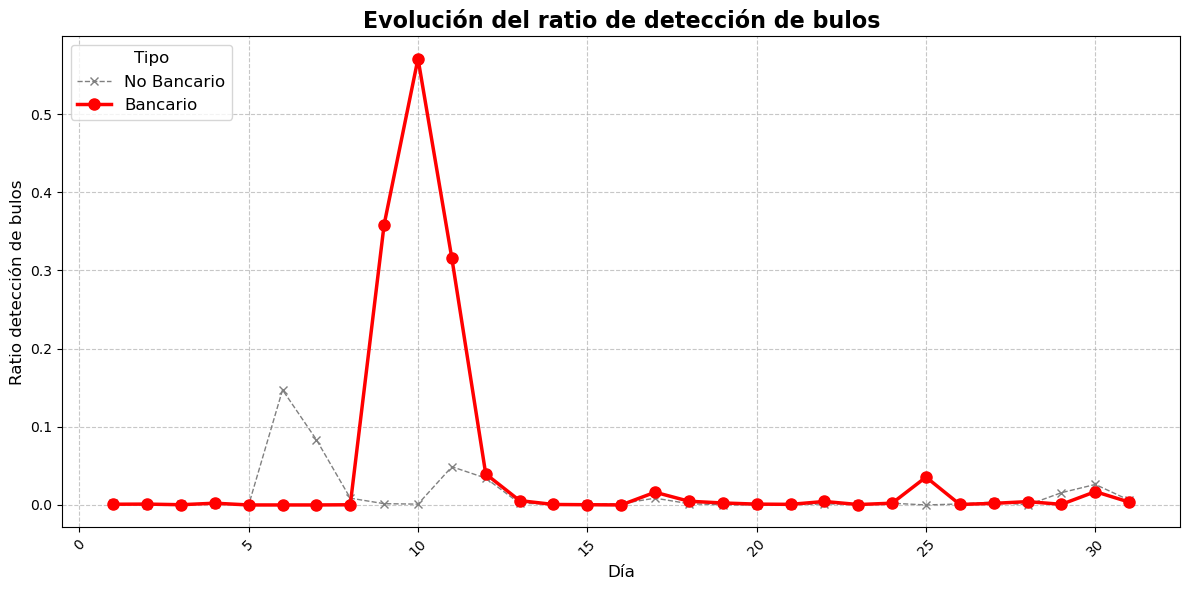

In [17]:
plt.figure(figsize=(12, 6))

# Colores y estilos para cada grupo
colores = {0: 'gray', 1: 'red'}
estilos = {0: '--', 1: '-'}
ancho_linea = {0: 1, 1: 2.5}
marcadores = {0: 'x', 1: 'o'}

# Graficar por separado para bancario y no bancario
for es_bancario in [0, 1]:
    data_tipo = df_metricas[df_metricas['es_bancario'] == es_bancario]
    plt.plot(data_tipo['dia'], data_tipo['ratio_bulos'], 
             label='Bancario' if es_bancario else 'No Bancario',
             color=colores[es_bancario],
             linestyle=estilos[es_bancario],
             linewidth=ancho_linea[es_bancario],
             marker=marcadores[es_bancario],
             markersize=8 if es_bancario else 6)

# Mejorar los ejes y el diseño del gráfico
plt.title('Evolución del ratio de detección de bulos', fontsize=16, fontweight='bold')
plt.xlabel('Día', fontsize=12)
plt.ylabel('Ratio detección de bulos', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='upper left', title='Tipo', title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


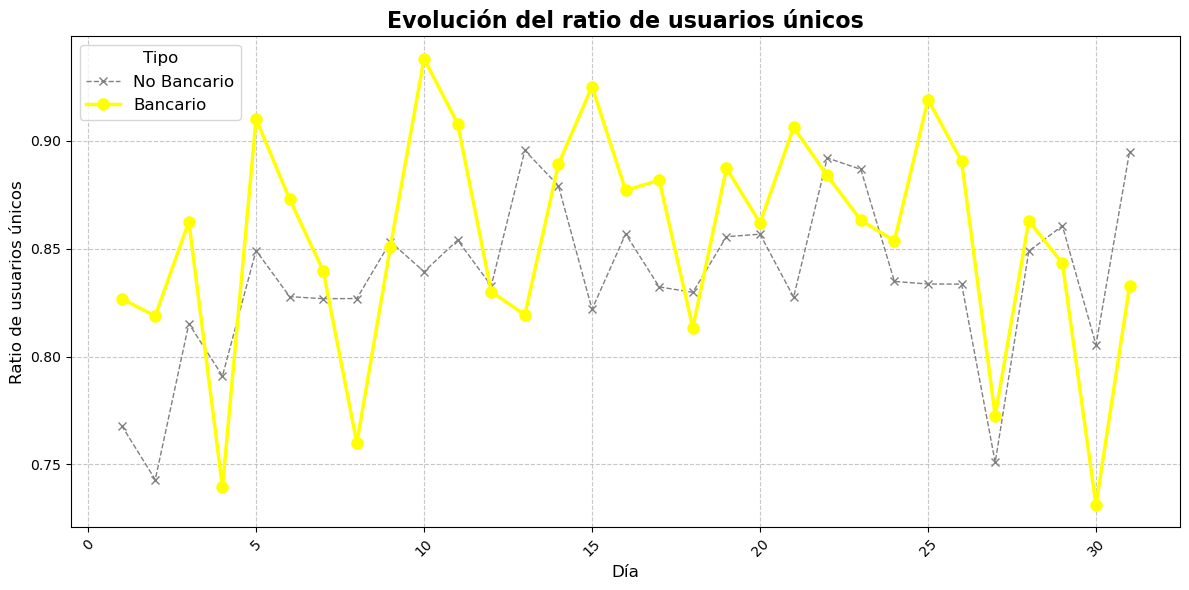

In [18]:
plt.figure(figsize=(12, 6))

# Colores y estilos para cada grupo
colores = {0: 'gray', 1: 'yellow'}
estilos = {0: '--', 1: '-'}
ancho_linea = {0: 1, 1: 2.5}
marcadores = {0: 'x', 1: 'o'}

# Graficar por separado para bancario y no bancario
for es_bancario in [0, 1]:
    data_tipo = df_metricas[df_metricas['es_bancario'] == es_bancario]
    plt.plot(data_tipo['dia'], data_tipo['ratio_usuarios'], 
             label='Bancario' if es_bancario else 'No Bancario',
             color=colores[es_bancario],
             linestyle=estilos[es_bancario],
             linewidth=ancho_linea[es_bancario],
             marker=marcadores[es_bancario],
             markersize=8 if es_bancario else 6)

# Mejorar los ejes y el diseño del gráfico
plt.title('Evolución del ratio de usuarios únicos', fontsize=16, fontweight='bold')
plt.xlabel('Día', fontsize=12)
plt.ylabel('Ratio de usuarios únicos', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='upper left', title='Tipo', title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


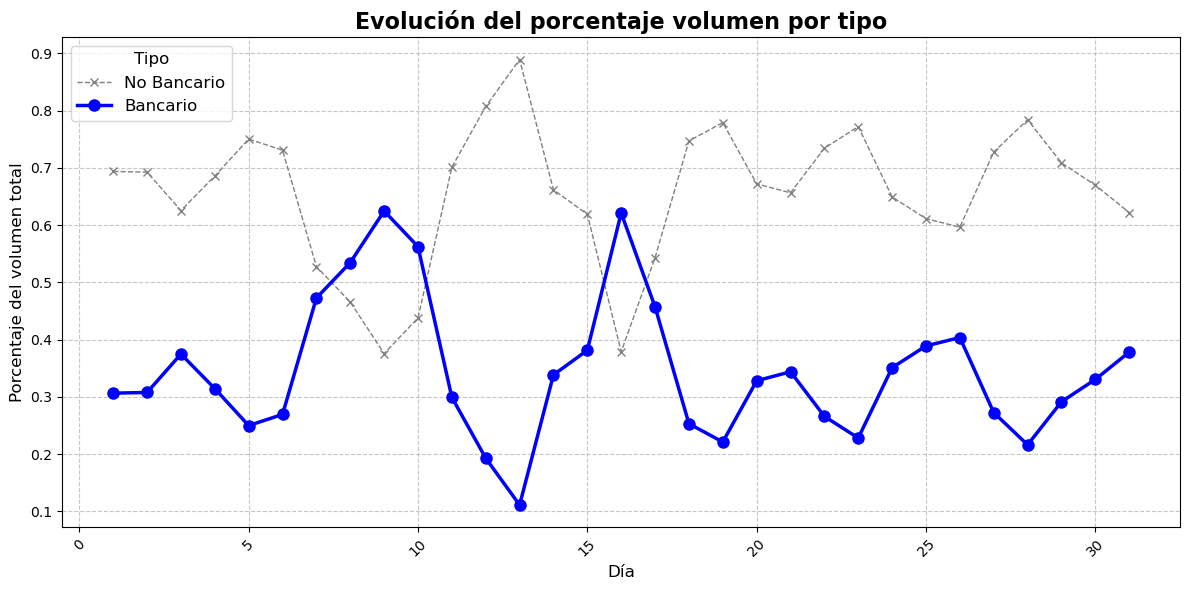

In [19]:
plt.figure(figsize=(12, 6))

# Colores y estilos para cada grupo
colores = {0: 'gray', 1: 'blue'}
estilos = {0: '--', 1: '-'}
ancho_linea = {0: 1, 1: 2.5}
marcadores = {0: 'x', 1: 'o'}

# Graficar por separado para bancario y no bancario
for es_bancario in [0, 1]:
    data_tipo = df_metricas[df_metricas['es_bancario'] == es_bancario]
    plt.plot(data_tipo['dia'], data_tipo['ratio_tipo'], 
             label='Bancario' if es_bancario else 'No Bancario',
             color=colores[es_bancario],
             linestyle=estilos[es_bancario],
             linewidth=ancho_linea[es_bancario],
             marker=marcadores[es_bancario],
             markersize=8 if es_bancario else 6)

# Mejorar los ejes y el diseño del gráfico
plt.title('Evolución del porcentaje volumen por tipo', fontsize=16, fontweight='bold')
plt.xlabel('Día', fontsize=12)
plt.ylabel('Porcentaje del volumen total', fontsize=12)
plt.xticks(rotation=45, fontsize=10)
plt.yticks(fontsize=10)
plt.legend(fontsize=12, loc='upper left', title='Tipo', title_fontsize=12)
plt.grid(True, linestyle='--', alpha=0.7)
plt.tight_layout()

# Mostrar el gráfico
plt.show()


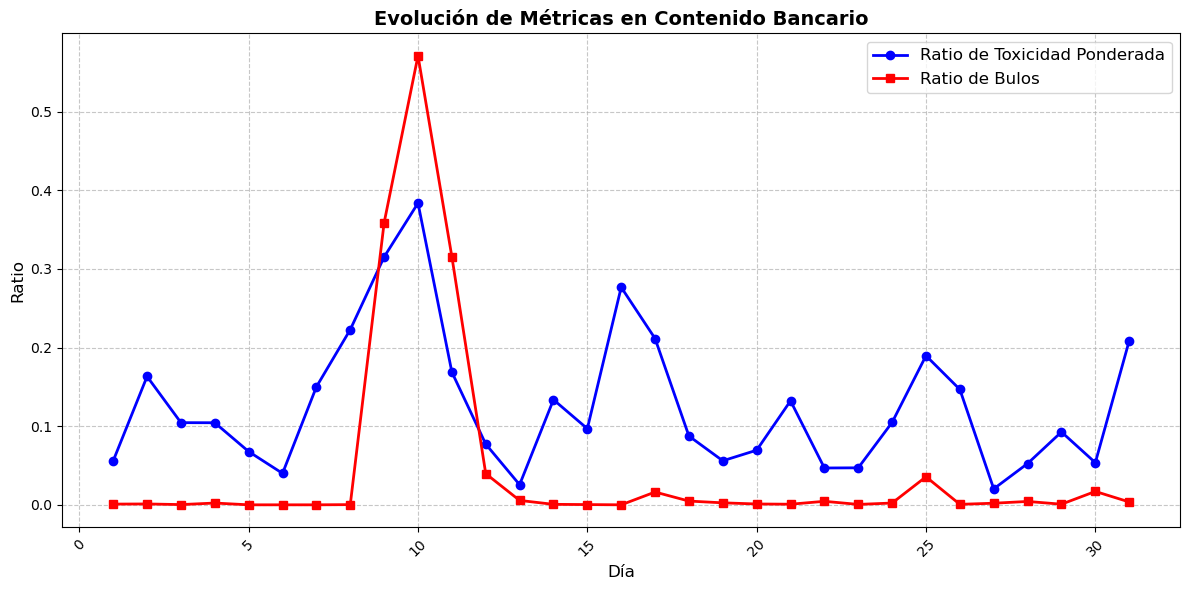

In [20]:
# Filtrar solo el contenido bancario
data_bancario = df_metricas[df_metricas['es_bancario'] == 1]

plt.figure(figsize=(12, 6))

# Graficar ambas métricas
plt.plot(data_bancario['dia'], data_bancario['ratio_toxicidad_ponderada'], 
         color='blue', label='Ratio de Toxicidad Ponderada', marker='o', linewidth=2)
plt.plot(data_bancario['dia'], data_bancario['ratio_bulos'], 
         color='red', label='Ratio de Bulos', marker='s', linewidth=2)

# Personalizar el gráfico
plt.title('Evolución de Métricas en Contenido Bancario', fontsize=14, fontweight='bold')
plt.xlabel('Día', fontsize=12)
plt.ylabel('Ratio', fontsize=12)
plt.xticks(rotation=45)
plt.grid(True, linestyle='--', alpha=0.7)
plt.legend(fontsize=12)
plt.tight_layout()

# Mostrar el gráfico
plt.show()

<Figure size 1200x600 with 0 Axes>

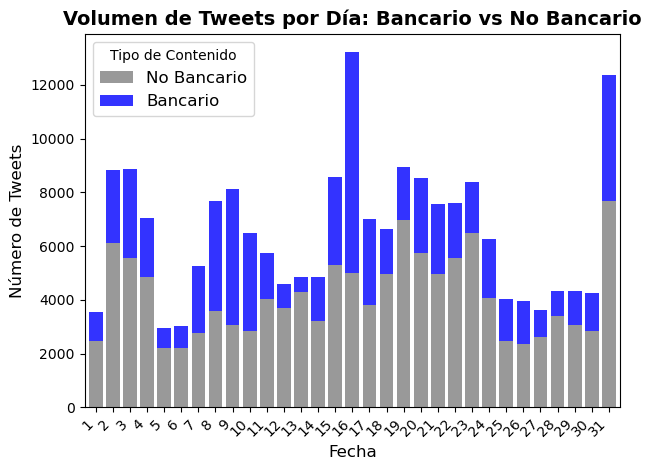

In [21]:
toxicidad_diaria = df_metricas.groupby(['dia', 'es_bancario']).agg({'total_tweets': 'sum'}).reset_index()
toxicidad_diaria = toxicidad_diaria.pivot(index='dia', columns='es_bancario', values='total_tweets').fillna(0)
toxicidad_diaria.columns = ['No Bancario', 'Bancario']

# Gráfico de barras apiladas
plt.figure(figsize=(12, 6))

# Graficar las barras apiladas
toxicidad_diaria.plot(kind='bar', stacked=True, color=['gray', 'blue'], alpha=0.8, width=0.8)

# Configuración del gráfico
plt.title('Volumen de Tweets por Día: Bancario vs No Bancario', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Tweets', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.legend(title='Tipo de Contenido', labels=['No Bancario', 'Bancario'], fontsize=12)
plt.tight_layout()

# Mostrar gráfico
plt.show()

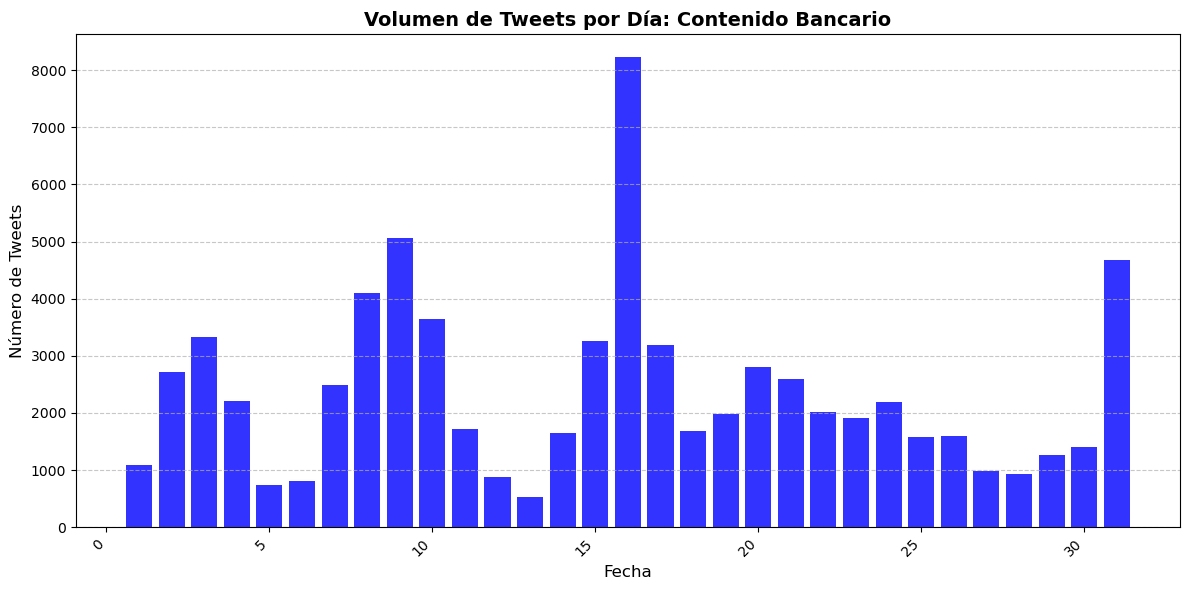

In [22]:
toxicidad_bancaria = df_metricas[df_metricas['es_bancario'] == 1].groupby('dia')['total_tweets'].sum().reset_index()

# Gráfico de barras
plt.figure(figsize=(12, 6))
plt.bar(toxicidad_bancaria['dia'], toxicidad_bancaria['total_tweets'], color='blue', alpha=0.8, width=0.8)

# Configuración del gráfico
plt.title('Volumen de Tweets por Día: Contenido Bancario', fontsize=14, fontweight='bold')
plt.xlabel('Fecha', fontsize=12)
plt.ylabel('Número de Tweets', fontsize=12)
plt.xticks(rotation=45, ha='right')
plt.grid(axis='y', linestyle='--', alpha=0.7)

# Mostrar gráfico
plt.tight_layout()
plt.show()


# Análisis de Franjas Temporales Críticas

Procederemos a analizar las cuatro franjas temporales identificadas, caracterizando cada periodo a través de las narrativas dominantes en sus clusters más relevantes. Esto nos permitirá entender:

1. **Primera franja (2-4 de octubre):**

2. **Segunda franja (8-10 de octubre):**  

3. **Tercera franja (15-17 de octubre):**  

4. **Cuarta franja (24-26 de octubre):**  
   
5. **Última franja (31 de octubre):**  


### Función para analizar cluster

In [25]:
def analizar_cluster(cluster_id, fecha, df_main, df_metadata):
   """
   Realiza un análisis completo de un cluster específico en una fecha dada
   """
   dia = pd.to_datetime(fecha).date()
   
   # Filtrar tweets del cluster y día
   tweets_cluster = df_main[
       (df_main.cluster_id == cluster_id) & 
       (df_main.date.dt.date == dia)
   ].copy()
   
   # Análisis de tipos de tweets
   tweets_originales = tweets_cluster[tweets_cluster.type != 'Retweet']
   retweets = tweets_cluster[tweets_cluster.type == 'Retweet']
   
   print(f"===== Análisis del Cluster {cluster_id} - {dia} =====\n")
   
   # Información básica y narrativa
   print("INFORMACIÓN GENERAL")
   print("-" * 50)
   print(f"Narrativa: {df_metadata[df_metadata.cluster_id == cluster_id].narrative.values[0]}")
   print(f"Total tweets: {len(tweets_cluster)}")
   print(f"- Tweets originales: {len(tweets_originales)}")
   print(f"- Retweets: {len(retweets)}")
   
   # Análisis de contenido
   print("\nANÁLISIS DE CONTENIDO")
   print("-" * 50)
   print(f"Textos únicos en retweets: {retweets.text.nunique()}")
   print("\nDistribución de retweets:")
   print(retweets.text.value_counts())
   
   if len(tweets_originales) > 0:
       print("\nTextos originales:")
       for text in tweets_originales.text.values:
           print(f"- {text}")
   
   # Análisis temporal
   print("\nPROPAGACIÓN TEMPORAL")
   print("-" * 50)
   propagacion = tweets_cluster.groupby(tweets_cluster.date.dt.hour).size().reset_index(name='tweets')
   print(propagacion)
   
   # Análisis de usuarios
   print("\nANÁLISIS DE USUARIOS")
   print("-" * 50)
   calidad_usuarios = tweets_cluster.agg({
       'user.id': 'nunique',
       'user.followers': lambda x: x.astype(float).mean(),
       'user.friends': 'mean'
   }).round(2)
   print("\nMétricas de usuarios:")
   print(calidad_usuarios)
   
   # Distribución de seguidores
   def get_follower_range(followers):
       try:
           followers = float(followers)
           if followers == 0: return '0 seguidores'
           elif followers < 100: return '<100 seguidores'
           elif followers < 1000: return '100-1000 seguidores'
           elif followers < 10000: return '1k-10k seguidores'
           else: return '>10k seguidores'
       except:
           return 'N/A'
   
   distribucion = tweets_cluster['user.followers'].apply(get_follower_range).value_counts()
   print("\nDistribución por número de seguidores:")
   print(distribucion)


def analizar_clusters_top(dias_toxicos, df_main_clusters_ampliado):
    """
    Función para analizar los top 5 clusters para cada día tóxico, calculando estadísticas relevantes como la toxicidad,
    el volumen de tweets, el alcance y otros ratios de interés.

    Args:
    dias_toxicos (list): Lista de fechas (datetime) que representan los días tóxicos.
    df_main_clusters_ampliado (DataFrame): DataFrame que contiene los datos de los tweets, incluyendo columnas como
                                           'dia', 'cluster_id', 'toxic', 'alcance_promedio_tweet', 'num_keyword_bancaria', 
                                           y 'claim_url_bool'.
    """
    for dia in dias_toxicos:
        # Filtrar por el día específico
        tweets_del_dia = df_main_clusters_ampliado[
            df_main_clusters_ampliado['date'].dt.date == dia.date()
        ]
        
        # Contar frecuencia de clusters
        top_clusters = tweets_del_dia['cluster_id'].value_counts().head(5)
        
        # Obtener ratios de toxicidad para estos clusters
        cluster_stats = tweets_del_dia[tweets_del_dia['cluster_id'].isin(top_clusters.index)].groupby('cluster_id').agg({
            'toxic': 'mean',
            'cluster_id': 'count',
            'alcance_promedio_tweet': 'first',
            'es_bancario': 'mean',
            'claim_url_bool': 'mean'  # Añadido ratio de bulos
        })
        
        # Ordenar por frecuencia
        cluster_stats = cluster_stats.reindex(top_clusters.index)
        
        print(f"\nTop clusters para {dia.strftime('%Y-%m-%d')}:")
        print(f"Toxicidad media del día: {tweets_del_dia['toxic'].mean():.3f}")
        print(f"Total tweets del día: {len(tweets_del_dia)}")
        print("\nCluster | Tweets | % del día | Toxicidad | Alcance | % Bancario | % Bulos")
        print("-" * 85)
        
        for cluster_id in cluster_stats.index:
            stats = cluster_stats.loc[cluster_id]
            tweets = stats['cluster_id']
            porcentaje_dia = (tweets / len(tweets_del_dia)) * 100
            toxicidad = stats['toxic']
            alcance = stats['alcance_promedio_tweet']
            bancario = stats['es_bancario'] * 100
            bulos = stats['claim_url_bool'] * 100  # Convertido a porcentaje
            
            print(f"Cluster {cluster_id:4d} | {tweets:6.0f} | {porcentaje_dia:8.1f}% | {toxicidad:9.3f} | {alcance:7.0f} | {bancario:8.1f}% | {bulos:6.1f}%")


def analizar_cluster_por_hora(cluster_id, fecha, df_main):
    """
    Función que grafica la cantidad de tweets por hora para un cluster dado en una fecha específica.
    
    Args:
    cluster_id (int): El identificador del cluster a analizar.
    fecha (str): Fecha en formato 'YYYY-MM-DD' para filtrar los tweets.
    df_main (DataFrame): DataFrame que contiene los tweets, incluyendo 'cluster_id' y 'date'.
    """
    dia = pd.to_datetime(fecha).date()
   
    # Filtrar tweets del cluster y día
    tweets_cluster = df_main[
        (df_main.cluster_id == cluster_id) & 
        (df_main.date.dt.date == dia)
    ].copy()
   
    # Agrupar los tweets por hora
    propagacion = tweets_cluster.groupby(tweets_cluster.date.dt.hour).size().reset_index(name='tweets')
    
    # Graficar la distribución de tweets por hora
    plt.figure(figsize=(10, 6))
    plt.bar(propagacion['date'], propagacion['tweets'], color='skyblue')
    plt.xlabel('Hora del día')
    plt.ylabel('Número de tweets')
    plt.title(f'Distribución de tweets por hora - Cluster {cluster_id} ({dia})')
    plt.xticks(range(24))
    plt.grid(True)
    plt.show()

In [26]:
primera_franja = [
    pd.to_datetime('2024-10-02'),
    pd.to_datetime('2024-10-03'),
    pd.to_datetime('2024-10-04')
]

segunda_franja = [
    pd.to_datetime('2024-10-08'),
    pd.to_datetime('2024-10-09'),
    pd.to_datetime('2024-10-10')
]

tercera_franja = [
    pd.to_datetime('2024-10-15'),
    pd.to_datetime('2024-10-16'),
    pd.to_datetime('2024-10-17')
]

cuarta_franja = [
    pd.to_datetime('2024-10-24'),
    pd.to_datetime('2024-10-25'),
    pd.to_datetime('2024-10-26')
]

ultima_franja = [
    pd.to_datetime('2024-10-31')
]

In [27]:
df_cluster_estatico.sort_values(by = 'tamaño',ascending = False).head(10)

,cluster_id,narrative,keywords_tratadas,es_bancario,tamaño,ratio_toxicos,ratio_bulos,ratio_sentimiento_neg,ratio_sarcasmo,ratio_insultos,ratio_discriminacion,ratio_amenazas,ratio_profanidad,ratio_retweets,tamaño_rel,followers_total,alcance_relativo,alcance_promedio_tweet
0,-1,En un contexto de crisis económica y desiguald...,"[crisis economica, oro, instituciones financie...",0,41585,0.290682,0.0,0.923434,0.243477,0.064543,0.025754,0.004858,0.002501,0.404136,0.206421,891027225,0.280159,21426.649633
365,364,"La directora del Banco Central Europeo, Christ...","[christine lagarde, banco central europeo, cam...",1,4476,0.997989,1.0,1.000000,0.000670,0.997319,0.000000,0.000000,0.000000,0.998436,0.022218,6177947,0.001942,1380.238382
198,197,"La sorprendente postura del Banco de España, q...","[banco de espana, progresista, gobierno, huelg...",1,3698,1.000000,1.0,1.000000,1.000000,0.000000,0.000000,0.000000,0.000000,0.999459,0.018356,2903754,0.000913,785.222823
795,794,Hoy se conmemora el 88 aniversario del saqueo ...,"[saqueo, cartagena, oro, memoria historica]",0,3483,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.017289,4234165,0.001331,1215.666092
447,446,Las donaciones generosas de grandes empresas c...,"[donaciones, dana, valencia, solidaridad]",0,3368,0.997922,0.0,1.000000,0.997922,0.000000,0.000000,0.000000,0.000000,0.997031,0.016718,3231533,0.001016,959.481295
481,480,Feijoo advierte que la corrupción ha alcanzado...,"[corrupcion, moncloa, feijoo, pp]",0,2835,1.000000,0.0,1.000000,0.999647,0.000353,0.000000,0.000000,0.000000,0.996120,0.014072,2813664,0.000885,992.474074
757,756,Un autor alega sufrir censura en redes sociale...,"[shadowbanning, censura, libro, figuras influy...",0,2411,0.000000,0.0,1.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.000000,0.011968,4019085,0.001264,1666.978432
629,628,La corrupción endémica en el Partido Popular s...,"[corrupcion, partido popular, rodrigo rato, ed...",0,2346,0.999574,0.0,1.000000,0.996164,0.003410,0.000000,0.000000,0.000000,0.992754,0.011645,3288999,0.001034,1401.960358
748,747,Un autor denuncia censura y shadow-banning tra...,"[censura, shadowbanning, libro, poderosos]",0,1878,0.000532,0.0,1.000000,0.000532,0.000000,0.000000,0.000000,0.000000,0.998935,0.009322,3148944,0.00099,1676.753994
246,245,Las campañas de fraude bancario se están inten...,"[fraude, suplantacion, ingenieria social, segu...",1,1722,0.000581,1.0,0.999419,0.002323,0.000000,0.000000,0.000000,0.000000,0.991289,0.008548,9990478,0.003141,5801.671312


## Primera franja (2-4 octubre)

In [29]:
for i, x in enumerate([primera_franja, segunda_franja, tercera_franja, cuarta_franja, ultima_franja], 1):
    print()
    print(f"Análisis de los clústers de la franja {i}")
    analizar_clusters_top(x, df_main_clusters_ampliado)


Análisis de los clústers de la franja 1

Top clusters para 2024-10-02:
Toxicidad media del día: 0.591
Total tweets del día: 8849

Cluster | Tweets | % del día | Toxicidad | Alcance | % Bancario | % Bulos
-------------------------------------------------------------------------------------
Cluster   -1 |   1608 |     18.2% |     0.419 |   21427 |      0.0% |    0.0%
Cluster  688 |   1427 |     16.1% |     0.996 |    2979 |      0.0% |    0.0%
Cluster  313 |    588 |      6.6% |     0.998 |    2291 |    100.0% |    0.0%
Cluster  729 |    467 |      5.3% |     0.019 |    2016 |      0.0% |    0.0%
Cluster  824 |    264 |      3.0% |     1.000 |    2362 |    100.0% |    0.0%

Top clusters para 2024-10-03:
Toxicidad media del día: 0.461
Total tweets del día: 8874

Cluster | Tweets | % del día | Toxicidad | Alcance | % Bancario | % Bulos
-------------------------------------------------------------------------------------
Cluster   -1 |   1997 |     22.5% |     0.258 |   21427 |      0.0% |

In [30]:
clusters_bancarios_franja1 = {
   313: {'tweets': 588, 'alcance': 2291, 'bulos': 0.0, 'porcentaje_dia': 6.6, 'dia': '2024-10-02'},
   824: {'tweets': 264, 'alcance': 2362, 'bulos': 0.0, 'porcentaje_dia': 3.0, 'dia': '2024-10-02'},
   689: {'tweets': 608, 'alcance': 3435, 'bulos': 0.0, 'porcentaje_dia': 6.9, 'dia': '2024-10-03'},
   97: {'tweets': 286, 'alcance': 1305, 'bulos': 0.0, 'porcentaje_dia': 4.1, 'dia': '2024-10-04'}
}

clusters_bancarios_franja2 = {
    691: {'tweets': 883, 'alcance': 1709, 'bulos': 0.0, 'porcentaje_dia': 11.5, 'dia': '2024-10-08'},
    737: {'tweets': 805, 'alcance': 1380, 'bulos': 0.0, 'porcentaje_dia': 10.5, 'dia': '2024-10-08'},
    364: {'tweets': 2078, 'alcance': 1380, 'bulos': 100.0, 'porcentaje_dia': 32.1, 'dia': '2024-10-10'},
    548: {'tweets': 651, 'alcance': 1356, 'bulos': 0.0, 'porcentaje_dia': 8.0, 'dia': '2024-10-09'},
    134: {'tweets': 236, 'alcance': 2040, 'bulos': 0.0, 'porcentaje_dia': 3.6, 'dia': '2024-10-10'}
}

clusters_bancarios_franja3 = {
    245: {'tweets': 1309, 'alcance': 5802, 'bulos': 0.0, 'porcentaje_dia': 15.3, 'dia': '2024-10-15'},
    678: {'tweets': 486, 'alcance': 1093, 'bulos': 0.0, 'porcentaje_dia': 5.7, 'dia': '2024-10-15'},
    197: {'tweets': 2689, 'alcance': 785, 'bulos': 0.0, 'porcentaje_dia': 20.3, 'dia': '2024-10-16'},
    598: {'tweets': 827, 'alcance': 1687, 'bulos': 0.0, 'porcentaje_dia': 6.2, 'dia': '2024-10-16'},
    328: {'tweets': 254, 'alcance': 43116, 'bulos': 18.9, 'porcentaje_dia': 3.6, 'dia': '2024-10-17'},
    352: {'tweets': 186, 'alcance': 1259, 'bulos': 0.0, 'porcentaje_dia': 2.7, 'dia': '2024-10-17'}
}

clusters_bancarios_franja4 = {
    333: {'tweets': 397, 'alcance': 1384, 'bulos': 0.0, 'porcentaje_dia': 6.3, 'toxicidad': 1.000, 'dia': '2024-10-24', 'porcentaje_bulos': 0.0},
    389: {'tweets': 262, 'alcance': 5414, 'bulos': 0.0, 'porcentaje_dia': 4.2, 'toxicidad': 0.000, 'dia': '2024-10-24', 'porcentaje_bulos': 0.0},
    420: {'tweets': 331, 'alcance': 1500, 'bulos': 0.0, 'porcentaje_dia': 8.4, 'toxicidad': 0.000, 'dia': '2024-10-26', 'porcentaje_bulos': 0.0},
    667: {'tweets': 301, 'alcance': 2768, 'bulos': 0.0, 'porcentaje_dia': 7.6, 'toxicidad': 0.960, 'dia': '2024-10-26', 'porcentaje_bulos': 0.0}
}


clusters_bancarios_ultima_franja = {
   94: {'tweets': 1317, 'alcance': 1127, 'bulos': 0.0, 'porcentaje_dia': 10.7, 'dia': '2024-10-31'},
   857: {'tweets': 775, 'alcance': 2139, 'bulos': 0.0, 'porcentaje_dia': 6.3, 'dia': '2024-10-31'}
}

clusters_bancarios = [
    clusters_bancarios_franja1,
    clusters_bancarios_franja2,
    clusters_bancarios_franja3,
    clusters_bancarios_franja4,
    clusters_bancarios_ultima_franja
]

In [31]:
def aplicar_analisis():
    # Unir todos los diccionarios de clusters en una lista
    all_clusters = [
        clusters_bancarios_franja1, 
        clusters_bancarios_franja2, 
        clusters_bancarios_franja3, 
        clusters_bancarios_ultima_franja, 
        clusters_bancarios_franja4
    ]

    # Iterar sobre todos los clusters
    for clusters in all_clusters:
        for cluster_id, data in clusters.items():
            x_cluster = cluster_id
            x_dia = data['dia']
            analizar_cluster(x_cluster, x_dia, df_main, df_metadata)

# Llamar la función para aplicar el análisis
aplicar_analisis()

===== Análisis del Cluster 313 - 2024-10-02 =====

INFORMACIÓN GENERAL
--------------------------------------------------
Narrativa: Los bancos españoles, como el Banco Santander y BBVA, son señalados por financiar las acciones violentas de Israel contra el pueblo palestino, generando un llamado a la conciencia pública sobre su papel en el conflicto y el negocio de armas en el que España está involucrada.
Total tweets: 588
- Tweets originales: 1
- Retweets: 587

ANÁLISIS DE CONTENIDO
--------------------------------------------------
Textos únicos en retweets: 1

Distribución de retweets:
text
RT @josevico4 Ojo a esto que cuenta @EconoCabreado y @ElSaltoDiario sobre los bancos que financian el genocidio.\nLa gente debe saberlo, sobre todo El Santander y BBVA.\nDifunde.\nhttps://t.co/ytbPADRHdo    587
Name: count, dtype: int64

Textos originales:
- El Diario también se hace eco de este estudio, bien, considerando cambiar de Banco ya @caixabank . España apoya por cierto y participa activ

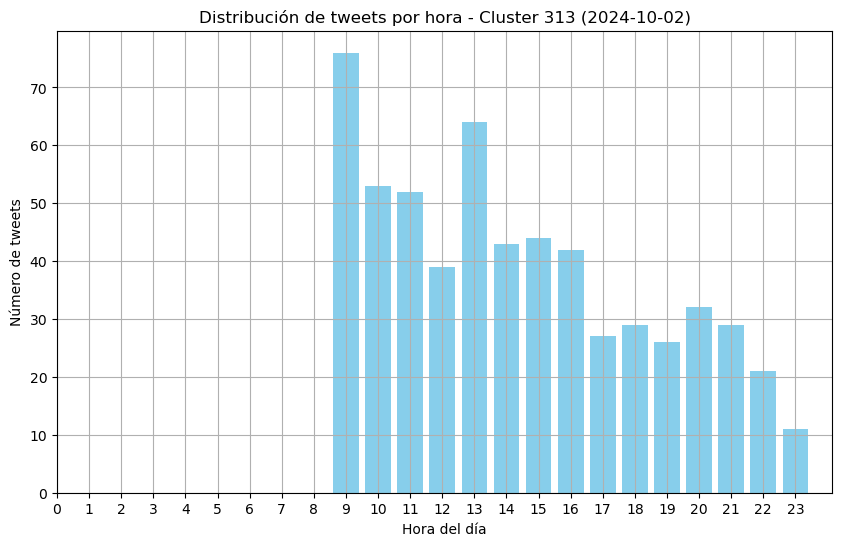

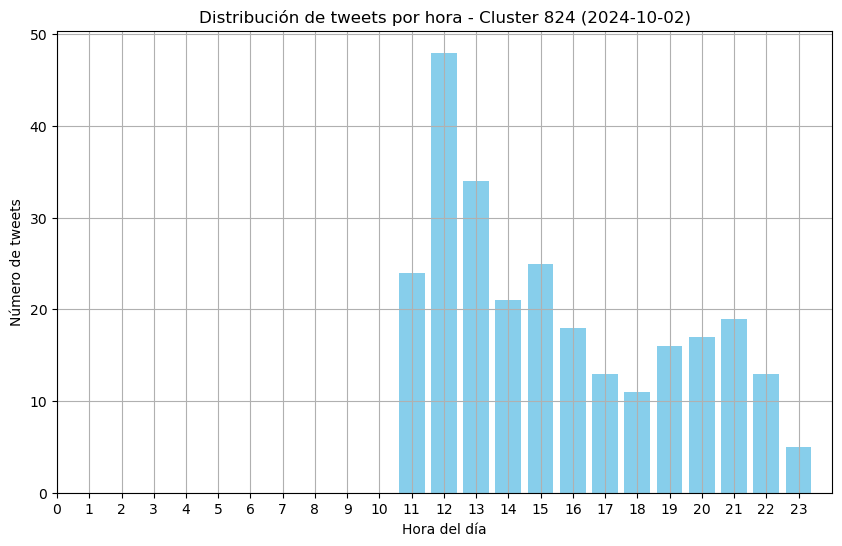

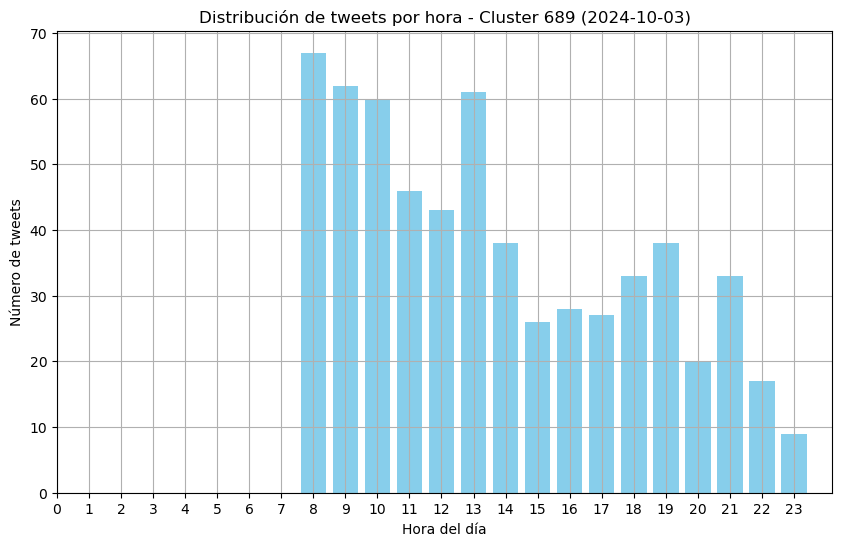

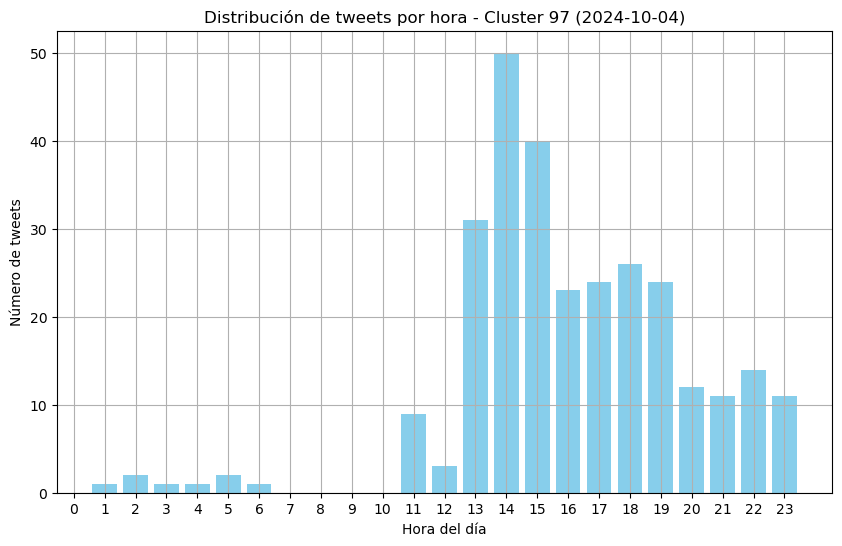

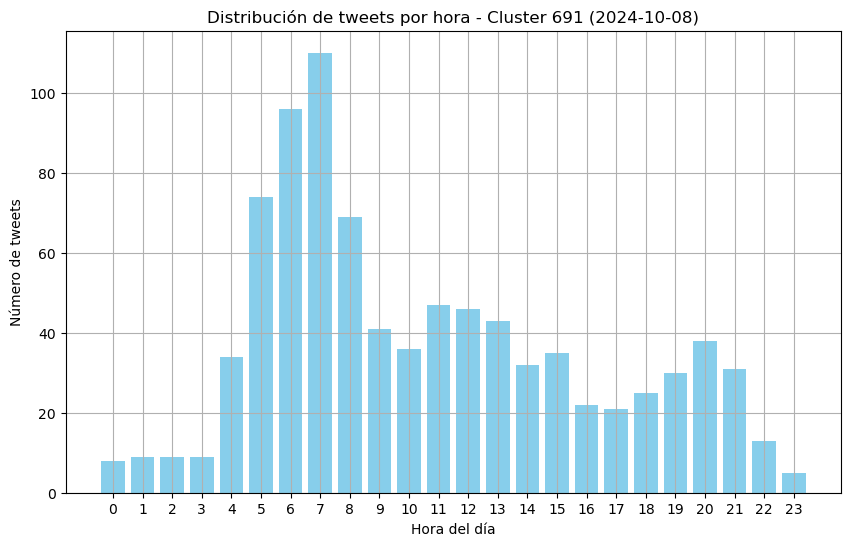

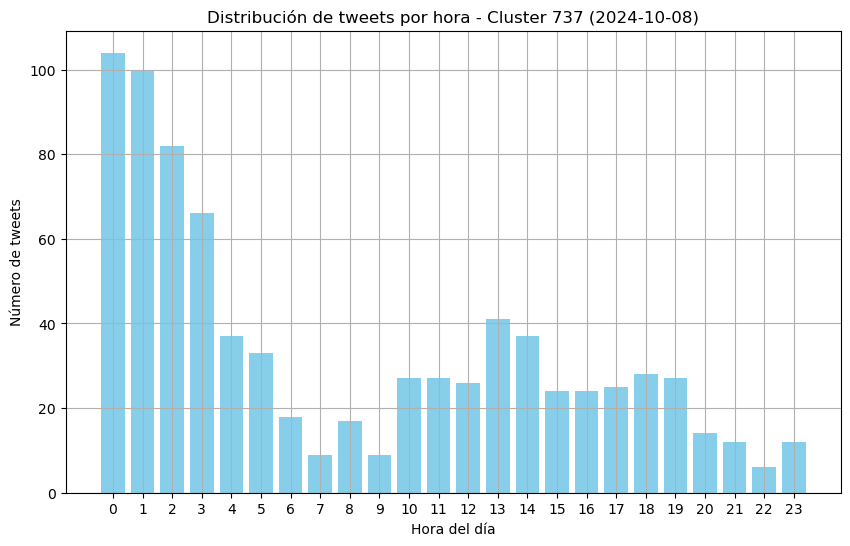

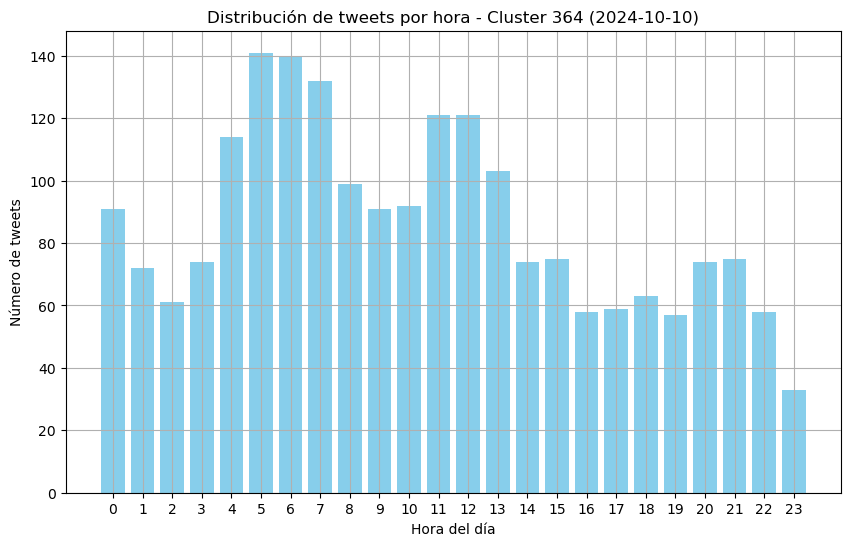

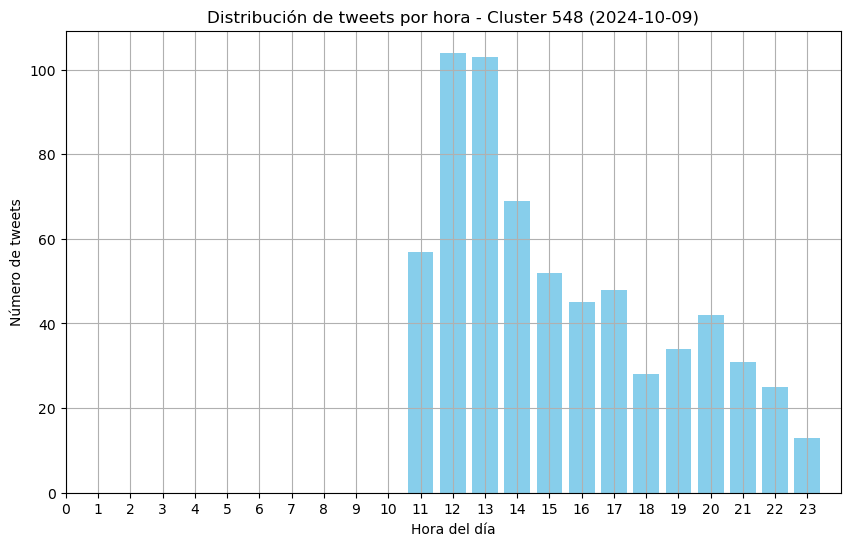

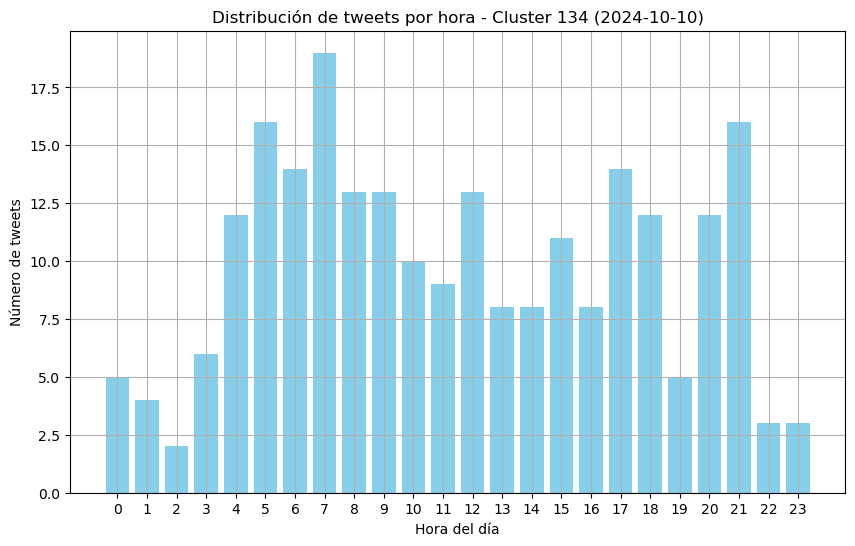

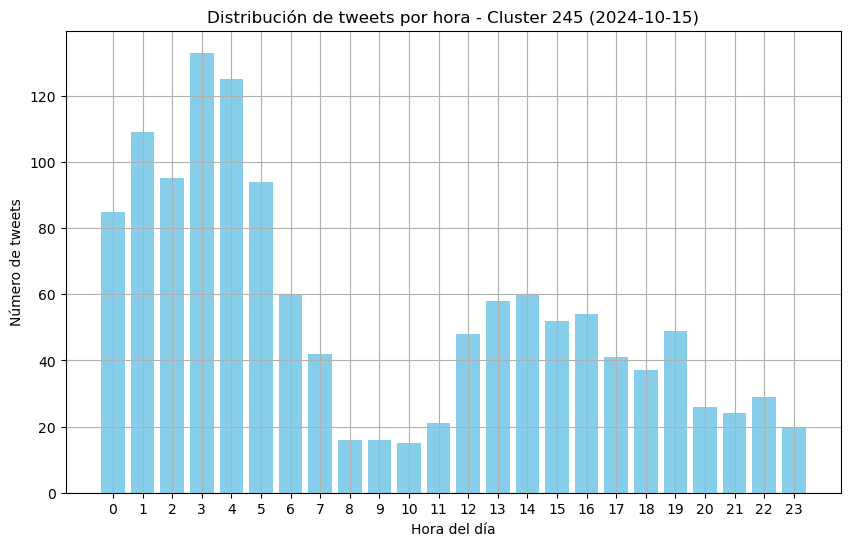

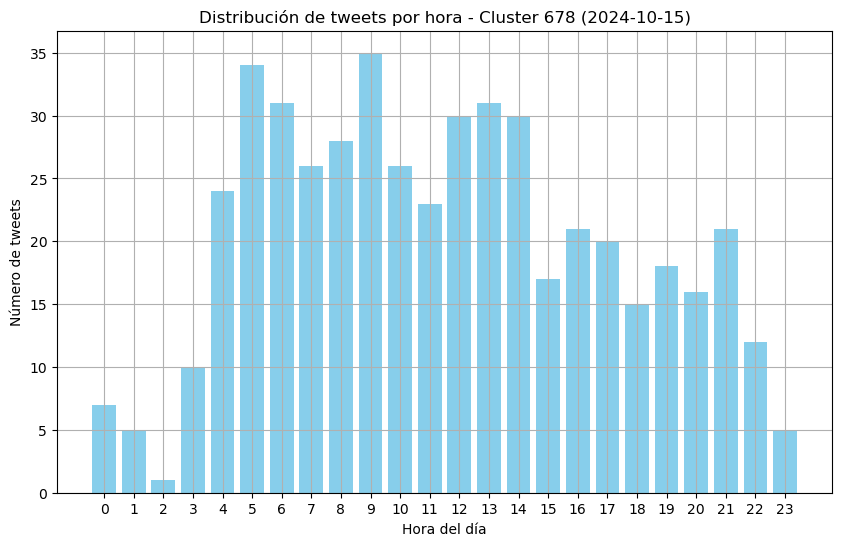

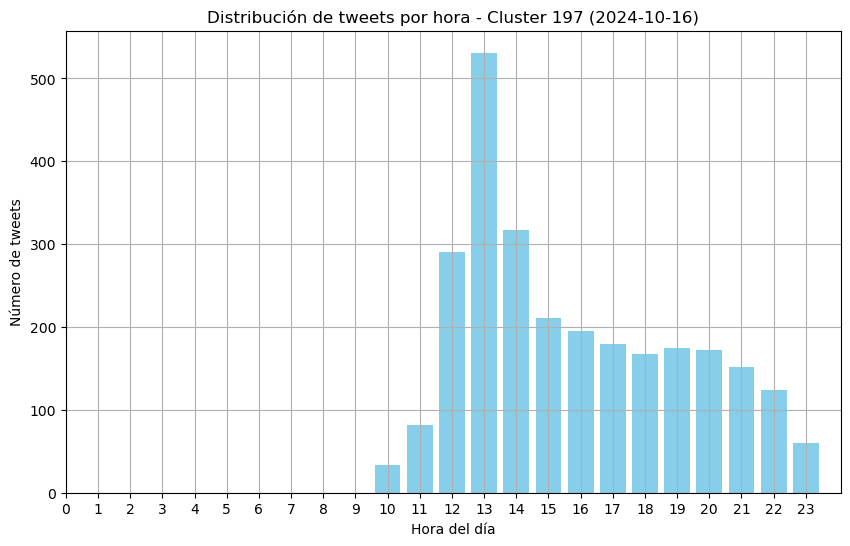

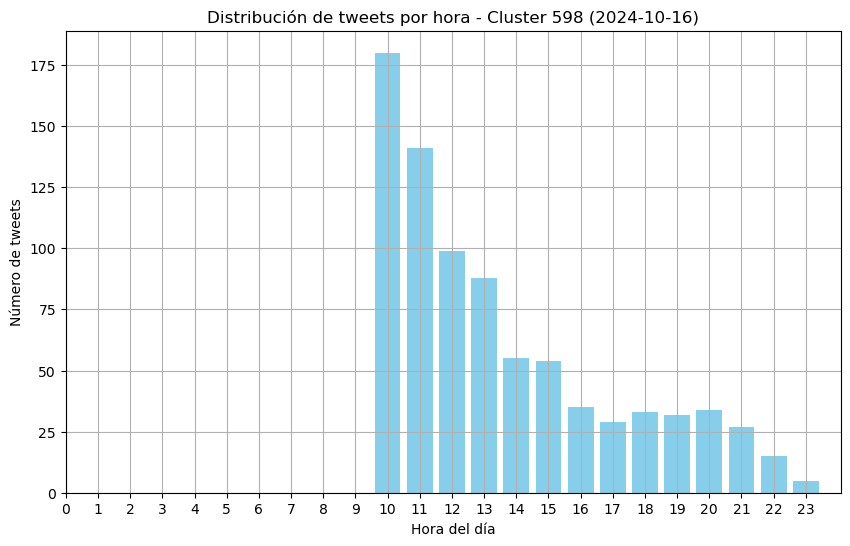

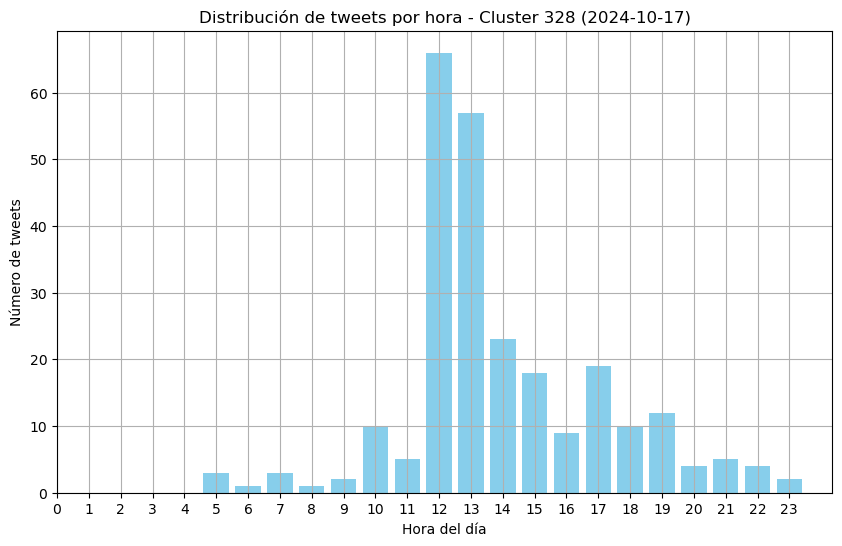

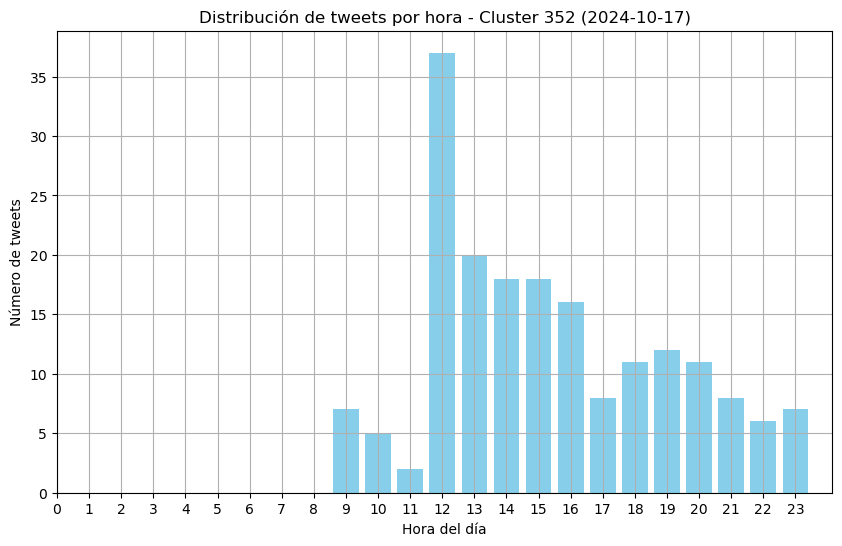

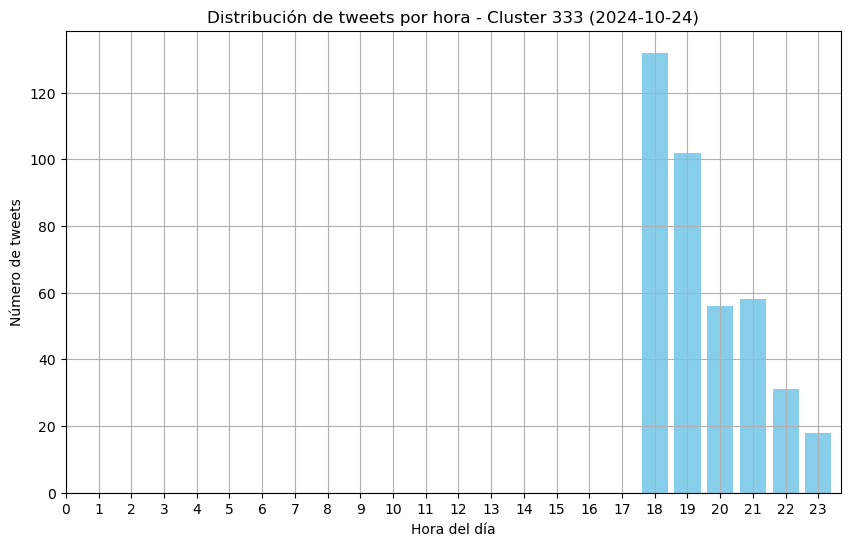

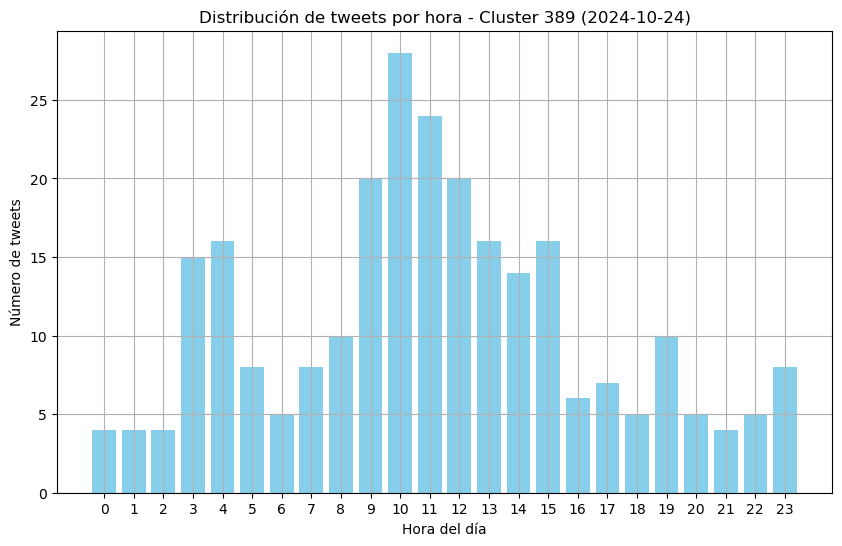

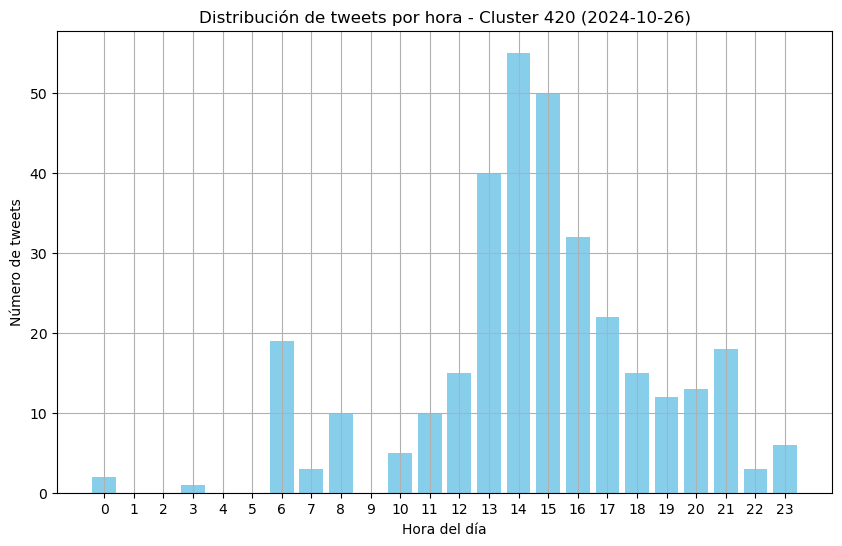

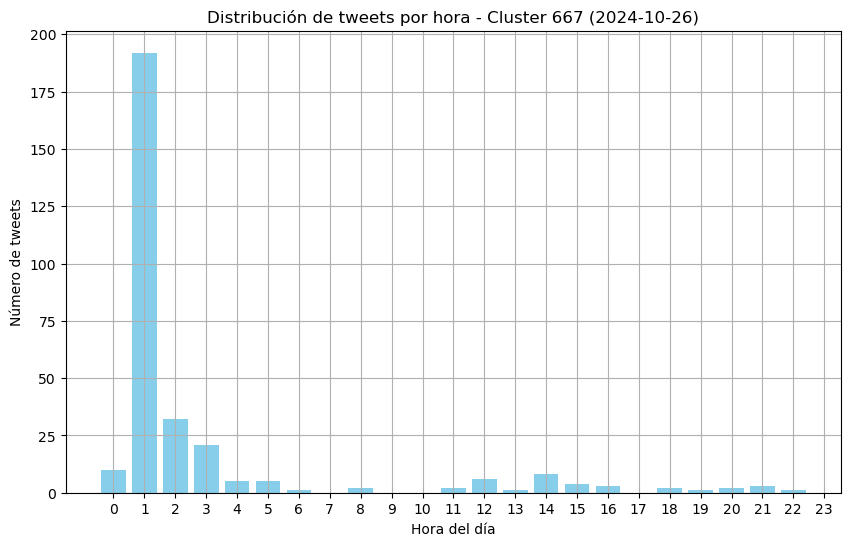

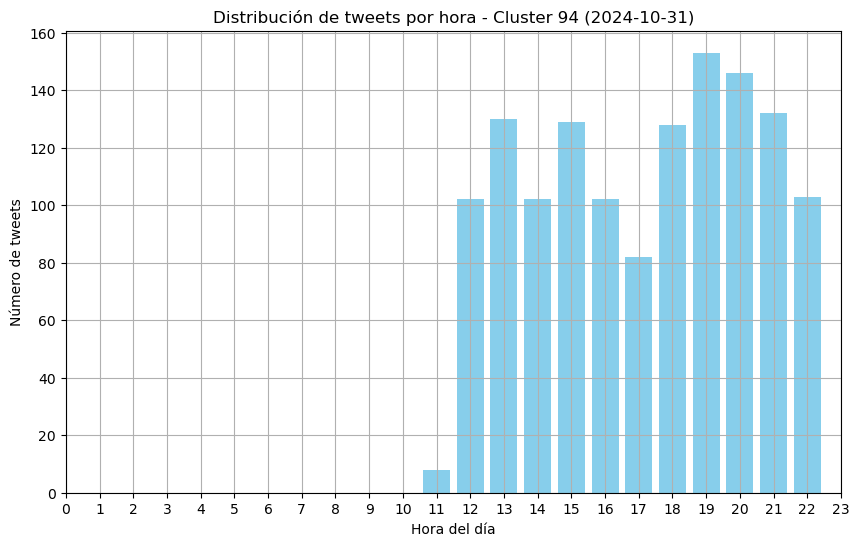

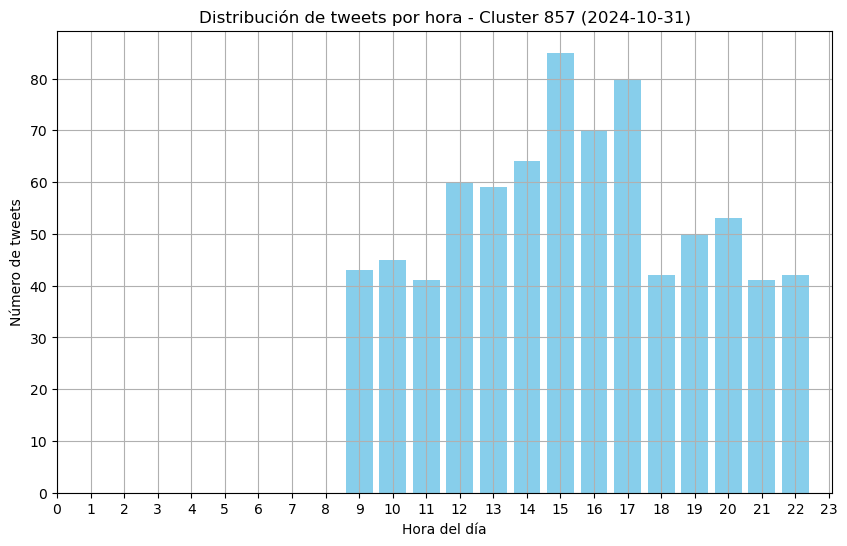

In [32]:
for franja in clusters_bancarios:
    for cluster_id, info in franja.items():
        # Obtener el día del cluster
        dia = info['dia']
        
        # Llamar a la función para analizar la propagación de tweets por hora
        analizar_cluster_por_hora(cluster_id, dia, df_main)